# PC-SAFT

The PC-SAFT implementation in teqp is based on the implementation of Gross and Sadowski (https://doi.org/10.1021/ie0003887), with the typo from their paper fixed.  It does NOT include the association contribution, only the dispersive contributions.

The model in teqp requires the user to specify the values of ``sigma``, ``epsilon/kB``, and ``m`` for each substance.  A very few substances are hardcoded in teqp, for testing purposes.  

In [1]:
import teqp
import numpy as np
teqp.__version__

'0.17.0'

In [2]:
TeXkey = 'Gross-IECR-2001'
ms = [1.0, 1.6069, 2.0020]
eoverk = [150.03, 191.42, 208.11]
sigmas = [3.7039, 3.5206, 3.6184]

coeffs = []
for i in range(len(ms)):
    c = teqp.SAFTCoeffs()
    c.m = ms[i]
    c.epsilon_over_k = eoverk[i]
    c.sigma_Angstrom = sigmas[i]
    coeffs.append(c)
    
model = teqp.PCSAFTEOS(coeffs)

In [3]:
# Here are some rudimentary timing results
T = 300.0
rhovec = np.array([3.0, 4.0, 5.0])
rho = rhovec.sum()
x = rhovec/np.sum(rhovec)
%timeit model.get_fugacity_coefficients(T,rhovec)
%timeit (-1.0)*model.get_Ar20(T, rho, x)
%timeit model.get_partial_molar_volumes(T, rhovec)

7.66 µs ± 38.9 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)
5.48 µs ± 7.9 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)
23.3 µs ± 386 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


The model parameters can be queried:

In [4]:
model.get_m(), model.get_epsilon_over_k_K(), model.get_sigma_Angstrom()

(array([1.    , 1.6069, 2.002 ]),
 array([150.03, 191.42, 208.11]),
 array([3.7039, 3.5206, 3.6184]))

## Adjusting k_ij

Fine-tuned values of $k_{ij}$ can be provided when instantiating the model.  A complete matrix of all the $k_{ij}$ values must be provided. This allows for asymmetric mixing models in which $k_{ij}\neq k_{ji}$.

In [5]:
k_01 = 0.01; k_10 = k_01
kmat = [[0,k_01,0],[k_10,0,0],[0,0,0]]
model = teqp.PCSAFTEOS(coeffs, kmat)

In [6]:
# and the matrix of parameters can be printed back out
model.get_kmat()

array([[0.  , 0.01, 0.  ],
       [0.01, 0.  , 0.  ],
       [0.  , 0.  , 0.  ]])

## Superancillary

The superancillary equation for PC-SAFT has been developed, and is much more involved than that of the cubic EOS. As a consequence, the superancillary equation has been provided as a separate package rather than integrating it into to teqp to minimize the binary size of teqp. It can be installed from PYPI with: ``pip install PCSAFTsuperanc``

The scaling in the superancillaries uses reduced variables:

$$ \tilde T = T/(\epsilon/k_{\rm B}) $$
$$ \tilde\rho = \rho_{\rm N}\sigma^3 $$

where $\rho_{\rm N}$ is the number density, and the other parameters are from the PC-SAFT model

In [7]:
import PCSAFTsuperanc

sigma_m = 3e-10 # [meter]
e_over_k = 150.0 # [K]
m = 5

# The saturation temperature
T = 300

[Ttilde_crit, Ttilde_min] = PCSAFTsuperanc.get_Ttilde_crit_min(m=m)
print('Ttilde crit:', Ttilde_crit)

# Get the scaled densities for liquid and vapor phases
[tilderhoL, tilderhoV] = PCSAFTsuperanc.PCSAFTsuperanc_rhoLV(Ttilde=T/e_over_k, m=m)
# Convert back to molar densities
N_A = PCSAFTsuperanc.N_A # The value of Avogadro's constant used in superancillaries
rhoL, rhoV = [tilderho/(N_A*sigma_m**3) for tilderho in [tilderhoL, tilderhoV]]

# As a sanity check, confirm that we got the same pressure in both phases
c = teqp.SAFTCoeffs()
c.sigma_Angstrom = sigma_m*1e10
c.epsilon_over_k = e_over_k 
c.m = m
model = teqp.PCSAFTEOS([c])
z = np.array([1.0])
pL = rhoL*model.get_R(z)*T*(1+model.get_Ar01(T, rhoL, z))
pV = rhoV*model.get_R(z)*T*(1+model.get_Ar01(T, rhoV, z))
print('Pressures are:', pL, pV, 'Pa')

Ttilde crit: 2.648680568587752
Pressures are: 227809.12314460654 227809.12314409122 Pa


## Maximum density

The maximum number density allowed by the EOS is defined based on the packing fraction. To get a molar density, divide by Avogadro's number. The function is conveniently exposed in Python:

In [8]:
max_rhoN = teqp.PCSAFTEOS(coeffs).max_rhoN(130.0, np.array([0.3, 0.3, 0.4]))
display(max_rhoN)
max_rhoN/6.022e23 # the maximum molar density in mol/m^3

1.9139171771761775e+28

31782.085306811314

## Polar contributions

As of teqp version 0.15, quadrupolar and dipolar contributions have been added to the hard chain plus dispersion model which is referred to conventionally as PC-SAFT. The definitions of the reduced dipolar and quadrupolar parameters are not well documented, so they are given here. The work of Stoll, Vrabec, and Hasse (https://doi.org/10.1063/1.1623475) clearly describes the formulation of the star-scaling. 

In SI units, the reduced squared dipole moment is defined by
$$
	(\mu^*)^2_{\rm conventional} = \frac{(\mu[Cm])^2}{4\pi\epsilon_0(\varepsilon[J])(\sigma[m])^3}
$$

$$
	(Q^*)^2_{\rm conventional} = \frac{(\mu[Cm])^2}{4\pi\epsilon_0(\varepsilon[J])(\sigma[m])^5}
$$

In the PC-SAFT formulation, the only difference is the addition of dividing the denominator by the number of segments $m$

$$
	(\mu^*)^2 = \frac{(\mu[Cm])^2}{4\pi\epsilon_0m(\varepsilon/k_{\rm B}[K])k_B(\sigma[m])^3}
$$
$$
(Q^*)^2 = \frac{(Q[Cm^2])^2}{4\pi\epsilon_0m(\varepsilon/k_B[K])k_B(\sigma[m])^5}
$$

The unit conversions are obtained from
$$
(\sigma[m]) = (10^{-10}m/A)(\sigma[A])
$$
$$
(\mu[Cm]) = (3.33564 \times 10^{-30}  Cm/D)(\mu[D])
$$
and $\epsilon_0=8.85419e-12$ C$^2$  N$^{-1}$ m$^{-2}$ is the permittivity of vacuum. 

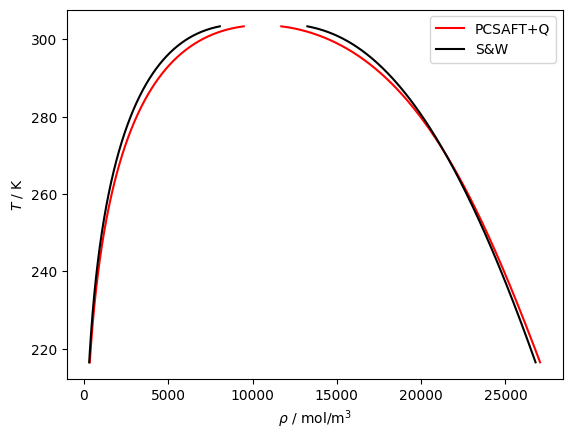

In [9]:
# CO2 with quadrupolar contributions
j = {
    'kind': 'PCSAFT',
    'model': {
        'coeffs': [{
            'name': 'CO2',
             'BibTeXKey': 'Gross-AICHEJ',
             'm': 1.5131,
             'sigma_Angstrom': 3.1869,
             'epsilon_over_k': 169.33,
             '(Q^*)^2': 1.26, # modified from the values in Gross and Vrabec since the base model is different
             'nQ': 1
        }]
    }
}

model = teqp.make_model(j)
Tc, rhoc = model.solve_pure_critical(300, 11000)

T = Tc*0.999
rhoL_, rhoV_ = model.extrapolate_from_critical(Tc, rhoc, T)
rhoL, rhoV = model.pure_VLE_T(T, rhoL_, rhoV_, 10)

import CoolProp.CoolProp as CP
import matplotlib.pyplot as plt
import pandas
o = []
for T_ in np.linspace(T, 215, 1000):
    rhoL, rhoV = model.pure_VLE_T(T_, rhoL, rhoV, 10)
    try:
        o.append({
          'T': T_, 'rhoL': rhoL, 'rhoV': rhoV, 
          'rhoLSW': CP.PropsSI('Dmolar','T',T_,'Q',0,'CO2'), 
          'rhoVSW': CP.PropsSI('Dmolar','T',T_,'Q',1,'CO2')
        })
    except:
        pass
df = pandas.DataFrame(o)
plt.plot(df['rhoL'], df['T'], 'r', label='PCSAFT+Q')
plt.plot(df['rhoV'], df['T'], 'r')
plt.plot(df['rhoLSW'], df['T'], 'k', label='S&W')
plt.plot(df['rhoVSW'], df['T'], 'k')
plt.legend()
plt.gca().set(xlabel=r'$\rho$ / mol/m$^3$', ylabel='$T$ / K')
plt.show()

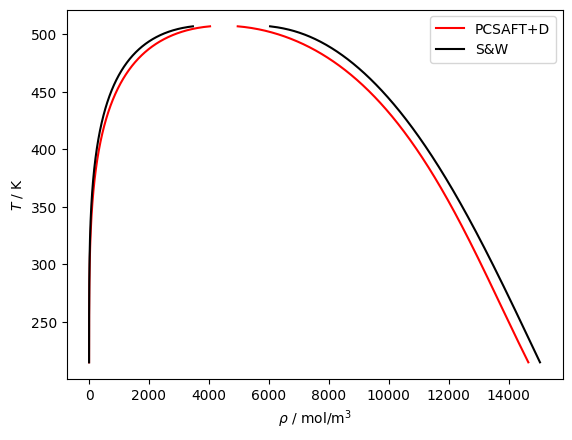

In [10]:
# Acetone with dipolar contributions
j = {
    'kind': 'PCSAFT',
    'model': {
        'coeffs': [{
            'name': 'acetone',
             'BibTeXKey': 'Gross-IECR',
             'm': 2.7447,
             'sigma_Angstrom': 3.2742,
             'epsilon_over_k': 232.99,
             '(mu^*)^2': 1.9, # modified from the values in Gross and Vrabec since the base model is different
             'nmu': 1
        }]
    }
}

model = teqp.make_model(j)
Tc, rhoc = model.solve_pure_critical(300, 11000)

T = Tc*0.999
rhoL_, rhoV_ = model.extrapolate_from_critical(Tc, rhoc, T)
rhoL, rhoV = model.pure_VLE_T(T, rhoL_, rhoV_, 10)

import CoolProp.CoolProp as CP
import matplotlib.pyplot as plt
import pandas
o = []
for T_ in np.linspace(T, 215, 1000):
    rhoL, rhoV = model.pure_VLE_T(T_, rhoL, rhoV, 10)
    try:
        o.append({
          'T': T_, 'rhoL': rhoL, 'rhoV': rhoV, 
          'rhoLSW': CP.PropsSI('Dmolar','T',T_,'Q',0,'acetone'), 
          'rhoVSW': CP.PropsSI('Dmolar','T',T_,'Q',1,'acetone')
        })
    except:
        pass
df = pandas.DataFrame(o)
plt.plot(df['rhoL'], df['T'], 'r', label='PCSAFT+D')
plt.plot(df['rhoV'], df['T'], 'r')
plt.plot(df['rhoLSW'], df['T'], 'k', label='S&W')
plt.plot(df['rhoVSW'], df['T'], 'k')
plt.legend()
plt.gca().set(xlabel=r'$\rho$ / mol/m$^3$', ylabel='$T$ / K')
plt.show()